<a href="https://www.kaggle.com/code/isseimatsuzoe/loan-approval-prediction?scriptVersionId=204293143" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv
/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv


## Request for Code Review and Suggestions 🌟

Hello Kaggle Community! 👋

I'm currently working on the competition *Loan Approval Prediction* and would love to receive any feedback or suggestions to improve my code.

### Specific Areas I'd Appreciate Help With:
- **Model Performance**: Any tips on improving accuracy or reducing overfitting?
- **Code Optimization**: Suggestions for making my code more efficient or readable.
- **Best Practices**: Advice on data handling, feature engineering, or anything else.

Feel free to leave comments directly on the code or below. Thank you in advance for your time and expertise! 😊

* Version 12 - Used the original dataset to train.
* Version 14 - Used optuna to tune the hyperparameters outside this notebook.

# Import Competition and Original Dataframes 

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm

In [26]:
train_comp_df = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv', index_col='id')
train_origin_df = pd.read_csv('/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv')
train_origin_df.index.name = 'id'
test_df = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv', index_col='id')
train_origin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [27]:
train_comp_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


# Clean up null values of the original data

In [28]:
train_origin_df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [29]:
# Remove the rows containign null values from original data.
train_origin_df.dropna(subset=['person_emp_length', 'loan_int_rate'], inplace=True)
train_origin_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28638 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  28638 non-null  int64  
 1   person_income               28638 non-null  int64  
 2   person_home_ownership       28638 non-null  object 
 3   person_emp_length           28638 non-null  float64
 4   loan_intent                 28638 non-null  object 
 5   loan_grade                  28638 non-null  object 
 6   loan_amnt                   28638 non-null  int64  
 7   loan_int_rate               28638 non-null  float64
 8   loan_status                 28638 non-null  int64  
 9   loan_percent_income         28638 non-null  float64
 10  cb_person_default_on_file   28638 non-null  object 
 11  cb_person_cred_hist_length  28638 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.8+ MB


In [30]:
#Concatnate original and competition dataframe to train
train_df = pd.concat([train_comp_df, train_origin_df], axis=0, ignore_index=True)
train_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87283 entries, 0 to 87282
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  87283 non-null  int64  
 1   person_income               87283 non-null  int64  
 2   person_home_ownership       87283 non-null  object 
 3   person_emp_length           87283 non-null  float64
 4   loan_intent                 87283 non-null  object 
 5   loan_grade                  87283 non-null  object 
 6   loan_amnt                   87283 non-null  int64  
 7   loan_int_rate               87283 non-null  float64
 8   loan_percent_income         87283 non-null  float64
 9   cb_person_default_on_file   87283 non-null  object 
 10  cb_person_cred_hist_length  87283 non-null  int64  
 11  loan_status                 87283 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 8.0+ MB


# Feature Meanings
* person age; age of the applicants
* person_income; income of the applicants
* person_home_ownership; the type of applicants' home ownership
* loan_intent; applicants' loan intent
* loan_grade; the credit grade A to E
* loan_percent_income; the ratio of the loan to the income
* cb_person_default_on_file; applicants' record of history wether they had defaulted(Y) or not(N). need to check data leakage
* cb_person_cred_length; length of applicants' credit histroy
* loan_status; wether the applicants' requested had been approved(0) or not(1)

# EDA

In [32]:
train_df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,87283.000000,8.728300e+04,87283.000000,87283.000000,87283.000000,87283.000000,87283.000000,87283.000000
mean,27.608721,6.490030e+04,4.729776,9361.573869,10.796646,0.162601,5.807053,0.166733
std,6.126081,4.737024e+04,4.024940,5829.810576,3.104556,0.096881,4.032233,0.372740
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.000000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.700000e+04,4.000000,8000.000000,10.990000,0.140000,4.000000,0.000000
75%,30.000000,7.800000e+04,7.000000,12000.000000,13.110000,0.220000,8.000000,0.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87283 entries, 0 to 87282
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  87283 non-null  int64  
 1   person_income               87283 non-null  int64  
 2   person_home_ownership       87283 non-null  object 
 3   person_emp_length           87283 non-null  float64
 4   loan_intent                 87283 non-null  object 
 5   loan_grade                  87283 non-null  object 
 6   loan_amnt                   87283 non-null  int64  
 7   loan_int_rate               87283 non-null  float64
 8   loan_percent_income         87283 non-null  float64
 9   cb_person_default_on_file   87283 non-null  object 
 10  cb_person_cred_hist_length  87283 non-null  int64  
 11  loan_status                 87283 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 8.0+ MB


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='loan_amnt', ylabel='Density'>

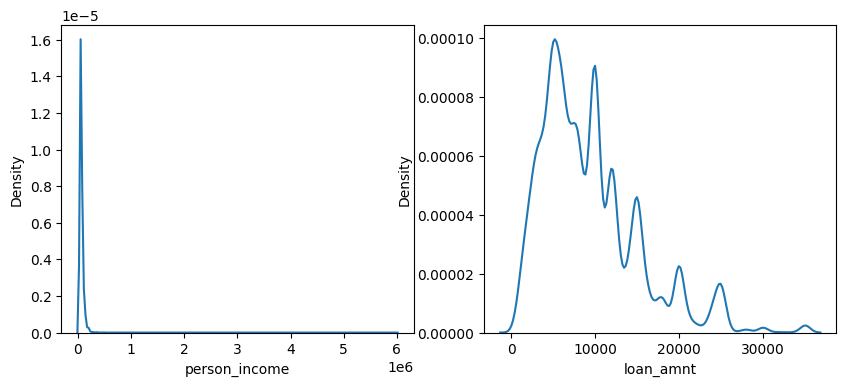

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.kdeplot(train_df['person_income'], ax=axes[0])
sns.kdeplot(train_df['loan_amnt'], ax=axes[1])

It looks the features need to be normalized for specific models.

In [35]:
categorical_cols = train_df.select_dtypes(include=['object']).columns
number_cols = train_df.select_dtypes(exclude='object').columns
number_df = train_df.select_dtypes(exclude='object')

<Axes: >

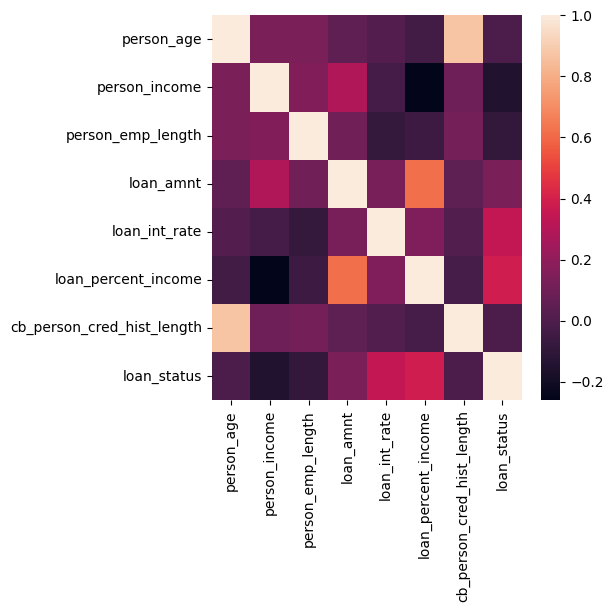

In [36]:
fig = plt.figure(figsize=(5, 5))
sns.heatmap(number_df.corr())

* person_age and person credit history are positively correrated
* person_income and loan_percent are negatively correlated

We can make density of the credit history by taking the ration of age and hist_length

In [37]:
train_df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [38]:
test_df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

No null values, this is good.

# Data Preprocessing
* We do not need to handling null values.
* Create new feature cred_hist_density.
* Do one-hot or ordinal encoding to the categorical features.

In [39]:
train_df['cred_hist_denity'] = train_df['cb_person_cred_hist_length'] / train_df['person_age']
test_df['cred_hist_denity'] = test_df['cb_person_cred_hist_length'] / test_df['person_age']
train_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,cred_hist_denity
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0,0.378378
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0,0.090909
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0,0.344828
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0,0.166667
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0,0.136364


In [40]:
train_df[categorical_cols].nunique()

person_home_ownership        4
loan_intent                  6
loan_grade                   7
cb_person_default_on_file    2
dtype: int64

* loan_grade has quality ordering; ordinal encoding
* cb_person_default_on_file; True or False
* The others are non-ordering; one-hot encoding

In [41]:
train_df['loan_intent'].unique()

array(['EDUCATION', 'MEDICAL', 'PERSONAL', 'VENTURE', 'DEBTCONSOLIDATION',
       'HOMEIMPROVEMENT'], dtype=object)

In [42]:
#Version 10: Used Ordinal encoding to all categorical features (Score: 0.95685)


train_df['loan_grade'] = train_df['loan_grade'].replace({'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0})
test_df['loan_grade'] = test_df['loan_grade'].replace({'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0})

train_df['cb_person_default_on_file'] = train_df['cb_person_default_on_file'].replace({'N': 0, 'Y': 1})
test_df['cb_person_default_on_file'] = test_df['cb_person_default_on_file'].replace({'N': 0, 'Y': 1})

ord_train_df = train_df.copy()
ord_test_df = test_df.copy()

#Change in the version 10
ord_train_df['person_home_ownership'] = train_df['person_home_ownership'].replace({'RENT': 0, 'OWN': 1, 'MORTGAGE': 2, 'OTHER': 3})
ord_test_df['person_home_ownership'] = test_df['person_home_ownership'].replace({'RENT': 0, 'OWN': 1, 'MORTGAGE': 2, 'OTHER': 3})

ord_train_df['loan_intent'] = train_df['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5})
ord_test_df['loan_intent'] = test_df['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5})

/tmp/ipykernel_30/798024494.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['loan_grade'] = train_df['loan_grade'].replace({'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0})
/tmp/ipykernel_30/798024494.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['loan_grade'] = test_df['loan_grade'].replace({'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0})
/tmp/ipykernel_30/798024494.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain th

In [43]:
#One-Hot Encoding (previous version and the score: 0.95917)
pp_train_df = pd.get_dummies(train_df, columns=['person_home_ownership', 'loan_intent'])
pp_test_df = pd.get_dummies(test_df, columns=['person_home_ownership', 'loan_intent'])
pp_train_df.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,...,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,37,35000,0.0,5,6000,11.49,0.17,0,14,0,...,False,False,False,True,False,True,False,False,False,False
1,22,56000,6.0,4,4000,13.35,0.07,0,2,0,...,False,False,True,False,False,False,False,True,False,False
2,29,28800,8.0,6,6000,8.90,0.21,0,10,0,...,False,False,True,False,False,False,False,False,True,False
3,30,70000,14.0,5,12000,11.11,0.17,0,5,0,...,False,False,False,True,False,False,False,False,False,True
4,22,60000,2.0,6,6000,6.92,0.10,0,3,0,...,False,False,False,True,False,False,False,True,False,False


In [44]:
pp_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87283 entries, 0 to 87282
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      87283 non-null  int64  
 1   person_income                   87283 non-null  int64  
 2   person_emp_length               87283 non-null  float64
 3   loan_grade                      87283 non-null  int64  
 4   loan_amnt                       87283 non-null  int64  
 5   loan_int_rate                   87283 non-null  float64
 6   loan_percent_income             87283 non-null  float64
 7   cb_person_default_on_file       87283 non-null  int64  
 8   cb_person_cred_hist_length      87283 non-null  int64  
 9   loan_status                     87283 non-null  int64  
 10  cred_hist_denity                87283 non-null  float64
 11  person_home_ownership_MORTGAGE  87283 non-null  bool   
 12  person_home_ownership_OTHER     

In [45]:
ord_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, 58645 to 97742
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  int64  
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  int64  
 5   loan_grade                  39098 non-null  int64  
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  int64  
 10  cb_person_cred_hist_length  39098 non-null  int64  
 11  cred_hist_denity            39098 non-null  float64
dtypes: float64(4), int64(8)
memory usage: 3.9 MB


All features are numbers or bool, done.

# Model Selection and Training
I will check the following 5 models
1. Logistic Regression
2. Random Forrest
3. XGB Classifier
4. Light GBM
5. SVM

In [46]:
# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
#Import Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM Classifier': SVC(),
    'XGB': XGBClassifier(),
    'LightGB': LGBMClassifier()}

results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}

X = pp_train_df.drop(['loan_status'], axis=1)
y = pp_train_df['loan_status']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

for i in models:
    #Fit the models
    model = models[i]
    model.fit(X_train, y_train)
    model_pred = model.predict(X_valid)
    
    #Calculate the scores
    accuracy = accuracy_score(y_valid, model_pred>0.5)
    precision = precision_score(y_valid, model_pred>0.5,average='weighted')
    recall = recall_score(y_valid, model_pred>0.5,average='weighted')
    f1 = f1_score(y_valid, model_pred>0.5,average='weighted')
    
    #Store the Results
    results['Model'].append(i)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1-Score'].append(f1)

results_df = pd.DataFrame(results)


print(results_df)

[LightGBM] [Info] Number of positive: 11643, number of negative: 58183
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 69826, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166743 -> initscore=-1.608888
[LightGBM] [Info] Start training from score -1.608888
                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.863321   0.846690  0.863321  0.843325
1        Random Forest  0.948559   0.948601  0.948559  0.945783
2       SVM Classifier  0.833305   0.777808  0.833305  0.757755
3                  XGB  0.948216   0.947390  0.948216  0.945975
4              LightGB  0.949590   0.949503  0.949590  0.947010


Let's choose LightGB model to my submission.

# Hyperparameter Tuning

In [47]:
import optuna

In [48]:
#Grid Search
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

my_model = LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=0, verbose=-1)

param_dist = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 300, 400],
    'num_leaves': [24, 31, 39],
    'max_depth': [-1],
    'min_child_samples': [0, 15, 30],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0],
    'reg_lambda': [0]}

random_search = RandomizedSearchCV(
    estimator=my_model,
    param_distributions=param_dist,
    n_iter=1,  # Number of parameter settings to sample. "currently set to 1 to save time"
    scoring='f1',  # Metric to optimize
    cv=5,  # Cross-validation folds
    verbose=2,
    random_state=0,
    n_jobs=4
)

random_search.fit(X_train, y_train)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best F1 Score: {random_search.best_score_}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'subsample': 0.5, 'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 24, 'n_estimators': 300, 'min_child_samples': 15, 'max_depth': -1, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Best F1 Score: 0.8202441241402688


In [49]:
#Best Parameters: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0, 'num_leaves': 31, 'n_estimators': 400, 'min_child_samples': 50, 'max_depth': 20, 'learning_rate': 0.03, 'colsample_bytree': 0.8}
#Best F1 Score: 0.8134012729242247

#2nd Best Parameters: {'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 24, 'n_estimators': 110, 'min_child_samples': 31, 'max_depth': -1, 'learning_rate': 0.09, 'colsample_bytree': 0.8}
#2nd Best F1 Score: 0.8131218852874698

In [56]:
#for lightgbm
dtrain = lightgbm.Dataset(X_train, label=y_train)
dvalid = lightgbm.Dataset(X_valid, label=y_valid, reference=dtrain)

# Submission

In [59]:
model_1 = LGBMClassifier(boosting_type='gbdt',
                         objective='binary',
                         random_state=0,
                         verbose=-1,
                         subsample=1.0,
                         reg_lambda=0.1,
                         reg_alpha=0,
                         num_leaves=31,
                         n_estimators=400,
                         min_child_samples=50,
                         max_depth=20,
                         learning_rate=0.03,
                         colsample_bytree=0.8)

model_2 = LGBMClassifier(boosting_type='gbdt',
                         objective='binary',
                         random_state=0,
                         verbose=-1,
                         subsample=1.0,
                         reg_lambda=0,
                          reg_alpha=0,
                          num_leaves=24,
                          n_estimators=110,
                          min_child_samples=31,
                          max_depth=-1,
                          learning_rate=0.09,
                          colsample_bytree=0.8)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 267,
    'reg_alpha': 3.2616071420435626e-06,
    'colsample_bytree': 0.7463784313235623,
    'max_depth': 21,
    'num_leaves': 116,
    'learning_rate': 0.0698584421279879,
    'feature_fraction': 0.6892321885788514,
    'bagging_fraction': 0.9444851959983321,
    'bagging_freq': 1,
    'min_child_samples': 34
}

model_optuna = LGBMClassifier(**params)
model_optuna.fit(X_train, y_train)
pred_optuna = model_optuna.predict(X_valid)

model_1.fit(X_train, y_train)
pred_1 = model_1.predict(X_valid)

model_2.fit(X_train, y_train)
pred_2 = model_2.predict(X_valid)

print("model_1; f1 scores is", f1_score(y_valid, pred_1>0.5,average='weighted'))
print("model_2; f1 scores is", f1_score(y_valid, pred_2>0.5,average='weighted'))
print("model_optuna; f1 scores is", f1_score(y_valid, pred_optuna>0.5,average='weighted'))
    

[LightGBM] [Warning] feature_fraction is set=0.6892321885788514, colsample_bytree=0.7463784313235623 will be ignored. Current value: feature_fraction=0.6892321885788514
[LightGBM] [Warning] bagging_fraction is set=0.9444851959983321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9444851959983321
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6892321885788514, colsample_bytree=0.7463784313235623 will be ignored. Current value: feature_fraction=0.6892321885788514
[LightGBM] [Warning] bagging_fraction is set=0.9444851959983321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9444851959983321
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 11643, number of negative: 58183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing

In [60]:
#V6: I found that pred_proba gives more good score on the result.
X_test = pp_test_df
preds = model_optuna.predict_proba(X_test)

# Save test predictions to file
output = pd.DataFrame({'id': X_test.index,
                       'loan_status': preds[:, 1]})
output.to_csv('submission.csv', index=False)

[LightGBM] [Warning] feature_fraction is set=0.6892321885788514, colsample_bytree=0.7463784313235623 will be ignored. Current value: feature_fraction=0.6892321885788514
[LightGBM] [Warning] bagging_fraction is set=0.9444851959983321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9444851959983321
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
